# PointNet Semantic Segmentation

**Author:** [Yimsungil](https://github.com/ClazyCoder)<br>
**Date Created:** 2022/03/13<br>
**Last Modified:** 2022/06/22<br>
**Description:** An implementation of a PointNet-based model for semantic segmentation of point clouds.<br>
Original Code : [Link](https://colab.research.google.com/github/keras-team/keras-io/blob/master/examples/vision/ipynb/pointnet_segmentation.ipynb)

## Imports

In [ ]:
import os
import json
import random
import numpy as np
import pandas as pd
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt

## Prepare the Dataset

Mount your drvie.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Upload the custom dataset.

In [ ]:
TRAIN_FILENAMES = glob('drive/MyDrive/pointnet/train/*.txt')
VAL_FILENAMES = glob('drive/MyDrive/pointnet/val/*.txt')
VAL_SPLIT = 0.2
NUM_SAMPLE_POINTS = 4096
BATCH_SIZE = 16
EPOCHS = 60
LABELS = ['back','desk','chair','cushion','monitor','book','wet_tissue','notepad','umbrella','gloves','marker']
INITIAL_LR = 1e-3 

In [ ]:
point_cloud_train_data, point_cloud_val_data = [], []
point_cloud_train_label, point_cloud_val_label = [], []

In [ ]:
# 컬러 데이터 추가
for filename in TRAIN_FILENAMES:
  print(filename)
  data = np.loadtxt(filename,np.float64)
  point_cloud_train_data.append(data[:,:6])
  point_cloud_train_label.append(data[:,6])
for filename in VAL_FILENAMES:
  print(filename)
  data = np.loadtxt(filename,np.float64)
  point_cloud_val_data.append(data[:,:6])
  point_cloud_val_label.append(data[:,6])

drive/MyDrive/pointnet/train/depth2022418-16h0m22s.txt
drive/MyDrive/pointnet/train/depth2022418-16h0m28s.txt
drive/MyDrive/pointnet/train/depth2022418-16h0m34s.txt
drive/MyDrive/pointnet/train/depth2022418-16h0m54s.txt
drive/MyDrive/pointnet/train/depth2022418-16h0m57s.txt
drive/MyDrive/pointnet/train/depth2022418-16h0m59s.txt
drive/MyDrive/pointnet/train/depth2022418-16h10m0s.txt
drive/MyDrive/pointnet/train/depth2022418-16h1m28s.txt
drive/MyDrive/pointnet/train/depth2022418-16h1m31s.txt
drive/MyDrive/pointnet/train/depth2022418-16h1m35s.txt
drive/MyDrive/pointnet/train/depth2022418-16h1m38s.txt
drive/MyDrive/pointnet/train/depth2022418-16h2m39s.txt
drive/MyDrive/pointnet/train/depth2022418-16h2m42s.txt
drive/MyDrive/pointnet/train/depth2022418-16h2m52s.txt
drive/MyDrive/pointnet/train/depth2022418-16h2m56s.txt
drive/MyDrive/pointnet/train/depth2022418-16h3m31s.txt
drive/MyDrive/pointnet/train/depth2022418-16h4m16s.txt
drive/MyDrive/pointnet/train/depth2022418-16h4m19s.txt
drive/MyDr

In [ ]:
print(point_cloud_train_data[0])

[[-130.15267944 -100.05225372  197.77085876  133.          133.
   133.        ]
 [-129.73321533 -100.05225372  197.77085876  133.          133.
   133.        ]
 [-142.24513245 -110.05747986  217.54794312  132.          132.
   133.        ]
 ...
 [  22.47058296   22.71671867   65.92362213    4.           11.
    17.        ]
 [  22.61040115   22.71671867   65.92362213    3.           11.
    15.        ]
 [  22.75022125   22.71671867   65.92362213    4.           10.
    15.        ]]


In [ ]:
label_data_train = []
label_data_val = []
for i in range(len(point_cloud_train_label)):
 data = keras.utils.to_categorical(point_cloud_train_label[i], num_classes=11)
 label_data_train.append(data)
for i in range(len(point_cloud_val_label)):
  data = keras.utils.to_categorical(point_cloud_val_label[i],num_classes=11)
  label_data_val.append(data)

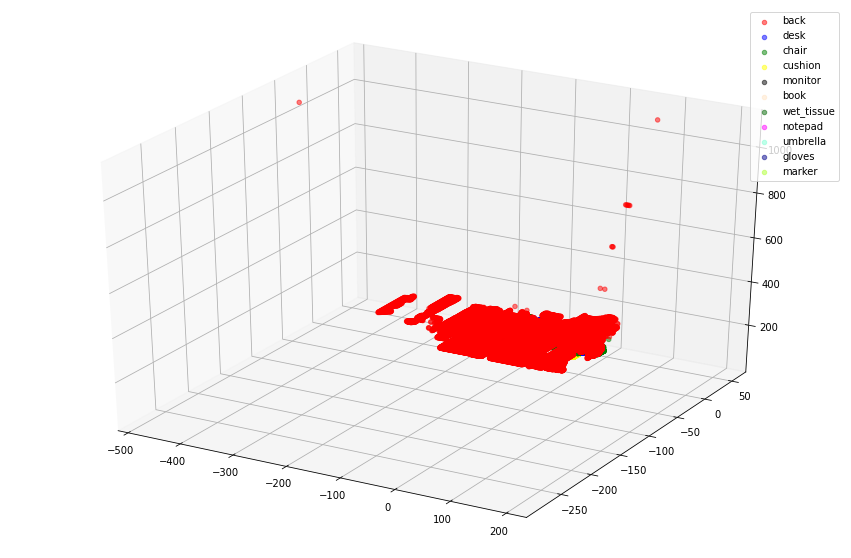

In [ ]:
def visualize_data(point_cloud, labels):
  COLORS = ['red','blue','green','yellow','black','bisque','darkgreen','magenta','aquamarine','darkblue','greenyellow']
  df = pd.DataFrame(
      data={
          "x": point_cloud[:, 0],
          "y": point_cloud[:, 1],
          "z": point_cloud[:, 2],
          "label": labels,
      }
  )
  fig = plt.figure(figsize=(15, 10))
  ax = plt.axes(projection="3d")
  for index, label in enumerate(LABELS):
      # if index == 0: continue
      c_df = df[df["label"] == index]
      try:
          ax.scatter(
              c_df["x"], c_df["y"], c_df["z"], label=label, alpha=0.5, c=COLORS[index]
          )
      except IndexError:
          pass
  ax.legend()
  plt.show()
visualize_data(point_cloud_train_data[0],point_cloud_train_label[0])

In [ ]:
print(label_data_train[0])

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]]


In [ ]:
# 컬러 데이터 추가.
for index in range(len(point_cloud_train_data)):
    current_point_cloud = point_cloud_train_data[index]
    current_label_cloud = label_data_train[index]
    num_points = len(current_point_cloud)
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    norm_point_cloud = sampled_point_cloud[:3] - np.mean(sampled_point_cloud[:3], axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud[:3], axis=1))
    sampled_point_cloud[0] = norm_point_cloud[0]
    sampled_point_cloud[1] = norm_point_cloud[1]
    sampled_point_cloud[2] = norm_point_cloud[2]
    point_cloud_train_data[index] = sampled_point_cloud
    label_data_train[index] = sampled_label_cloud
for index in range(len(point_cloud_val_data)):
    current_point_cloud = point_cloud_val_data[index]
    current_label_cloud = label_data_val[index]
    num_points = len(current_point_cloud)
    sampled_indices = random.sample(list(range(num_points)), NUM_SAMPLE_POINTS)
    sampled_point_cloud = np.array([current_point_cloud[i] for i in sampled_indices])
    sampled_label_cloud = np.array([current_label_cloud[i] for i in sampled_indices])
    norm_point_cloud = sampled_point_cloud - np.mean(sampled_point_cloud, axis=0)
    norm_point_cloud /= np.max(np.linalg.norm(norm_point_cloud, axis=1))
    sampled_point_cloud[0] = norm_point_cloud[0]
    sampled_point_cloud[1] = norm_point_cloud[1]
    sampled_point_cloud[2] = norm_point_cloud[2]
    point_cloud_val_data[index] = sampled_point_cloud
    label_data_val[index] = sampled_label_cloud

In [ ]:
# 컬러 데이터 추가
def load_data(point_cloud_batch, label_cloud_batch):
    point_cloud_batch.set_shape([NUM_SAMPLE_POINTS, 6])
    label_cloud_batch.set_shape([NUM_SAMPLE_POINTS, len(LABELS)])
    return point_cloud_batch, label_cloud_batch


def augment(point_cloud_batch, label_cloud_batch):
    noise = tf.random.uniform(
        tf.shape(label_cloud_batch), -0.005, 0.005, dtype=tf.float64
    )
    point_cloud_batch += noise[:, :, :6]
    return point_cloud_batch, label_cloud_batch


def generate_dataset(point_clouds, label_clouds, is_training=True):
    dataset = tf.data.Dataset.from_tensor_slices((point_clouds, label_clouds))
    dataset = dataset.shuffle(BATCH_SIZE * 100) if is_training else dataset
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size=BATCH_SIZE)
    dataset = (
        dataset.map(augment, num_parallel_calls=tf.data.AUTOTUNE)
        if is_training
        else dataset
    )
    return dataset


train_point_clouds = point_cloud_train_data
train_label_cloud = label_data_train
total_training_examples = len(train_point_clouds)

val_point_clouds = point_cloud_val_data
val_label_cloud = label_data_val

print("Num train point clouds:", len(train_point_clouds))
print("Num train point cloud labels:", len(train_label_cloud))
print("Num val point clouds:", len(val_point_clouds))
print("Num val point cloud labels:", len(val_label_cloud))

train_dataset = generate_dataset(train_point_clouds, train_label_cloud)
val_dataset = generate_dataset(val_point_clouds, val_label_cloud, is_training=False)

print("Train Dataset:", train_dataset)
print("Validation Dataset:", val_dataset)

Num train point clouds: 44
Num train point cloud labels: 44
Num val point clouds: 7
Num val point cloud labels: 7
Train Dataset: <ParallelMapDataset element_spec=(TensorSpec(shape=(None, 4096, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4096, 11), dtype=tf.float32, name=None))>
Validation Dataset: <BatchDataset element_spec=(TensorSpec(shape=(None, 4096, 6), dtype=tf.float64, name=None), TensorSpec(shape=(None, 4096, 11), dtype=tf.float32, name=None))>


In [ ]:
def conv_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Conv1D(filters, kernel_size=1, padding="valid", name=f"{name}_conv")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)


def mlp_block(x: tf.Tensor, filters: int, name: str) -> tf.Tensor:
    x = layers.Dense(filters, name=f"{name}_dense")(x)
    x = layers.BatchNormalization(momentum=0.0, name=f"{name}_batch_norm")(x)
    return layers.Activation("relu", name=f"{name}_relu")(x)

In [ ]:
class OrthogonalRegularizer(keras.regularizers.Regularizer):
    """Reference: https://keras.io/examples/vision/pointnet/#build-a-model"""

    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.identity = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.identity))

    def get_config(self):
        config = super(TransformerEncoder, self).get_config()
        config.update({"num_features": self.num_features, "l2reg_strength": self.l2reg})
        return config

In [ ]:
def transformation_net(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    """
    Reference: https://keras.io/examples/vision/pointnet/#build-a-model.

    The `filters` values come from the original paper:
    https://arxiv.org/abs/1612.00593.
    """
    x = conv_block(inputs, filters=64, name=f"{name}_1")
    x = conv_block(x, filters=128, name=f"{name}_2")
    x = conv_block(x, filters=1024, name=f"{name}_3")
    x = layers.GlobalMaxPooling1D()(x)
    x = mlp_block(x, filters=512, name=f"{name}_1_1")
    x = mlp_block(x, filters=256, name=f"{name}_2_1")
    return layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=keras.initializers.Constant(np.eye(num_features).flatten()),
        activity_regularizer=OrthogonalRegularizer(num_features),
        name=f"{name}_final",
    )(x)


def transformation_block(inputs: tf.Tensor, num_features: int, name: str) -> tf.Tensor:
    transformed_features = transformation_net(inputs, num_features, name=name)
    transformed_features = layers.Reshape((num_features, num_features))(
        transformed_features
    )
    return layers.Dot(axes=(2, 1), name=f"{name}_mm")([inputs, transformed_features])

In [ ]:
# 컬러데이터 추가
def get_shape_segmentation_model(num_points: int, num_classes: int) -> keras.Model:
    input_points = keras.Input(shape=(None, 6))

    # PointNet Classification Network.
    transformed_inputs = transformation_block(
        input_points, num_features=6, name="input_transformation_block"
    )
    features_64 = conv_block(transformed_inputs, filters=64, name="features_64")
    features_128_1 = conv_block(features_64, filters=128, name="features_128_1")
    features_128_2 = conv_block(features_128_1, filters=128, name="features_128_2")
    transformed_features = transformation_block(
        features_128_2, num_features=128, name="transformed_features"
    )
    features_512 = conv_block(transformed_features, filters=512, name="features_512")
    features_2048 = conv_block(features_512, filters=2048, name="pre_maxpool_block")
    global_features = layers.MaxPool1D(pool_size=num_points, name="global_features")(
        features_2048
    )
    global_features = tf.tile(global_features, [1, num_points, 1])

    # Segmentation head.
    segmentation_input = layers.Concatenate(name="segmentation_input")(
        [
            features_64,
            features_128_1,
            features_128_2,
            transformed_features,
            features_512,
            global_features,
        ]
    )
    segmentation_features = conv_block(
        segmentation_input, filters=128, name="segmentation_features"
    )
    outputs = layers.Conv1D(
        num_classes, kernel_size=1, activation="softmax", name="segmentation_head"
    )(segmentation_features)
    return keras.Model(input_points, outputs)

In [ ]:
x, y = next(iter(train_dataset))

num_points = x.shape[1]
num_classes = y.shape[-1]

segmentation_model = get_shape_segmentation_model(num_points, num_classes)
segmentation_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 6)]    0           []                               
                                                                                                  
 input_transformation_block_1_c  (None, None, 64)    448         ['input_1[0][0]']                
 onv (Conv1D)                                                                                     
                                                                                                  
 input_transformation_block_1_b  (None, None, 64)    256         ['input_transformation_block_1_co
 atch_norm (BatchNormalization)                                  nv[0][0]']                       
                                                                                              

Total training steps: 120.


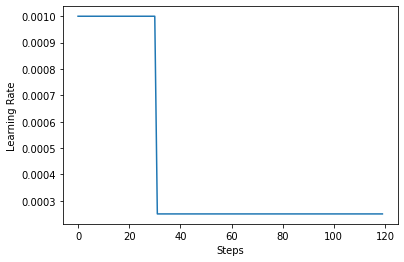

In [ ]:
training_step_size = total_training_examples // BATCH_SIZE
total_training_steps = training_step_size * EPOCHS
print(f"Total training steps: {total_training_steps}.")

lr_schedule = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[training_step_size * 15, training_step_size * 15],
    values=[INITIAL_LR, INITIAL_LR * 0.5, INITIAL_LR * 0.25],
)

steps = tf.range(total_training_steps, dtype=tf.int32)
lrs = [lr_schedule(step) for step in steps]

plt.plot(lrs)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

In [ ]:
def run_experiment(epochs):

    segmentation_model = get_shape_segmentation_model(num_points, num_classes)
    segmentation_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss=keras.losses.CategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_loss",
        save_best_only=True,
        save_weights_only=True,
    )

    history = segmentation_model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=epochs,
        callbacks=[checkpoint_callback],
    )

    segmentation_model.load_weights(checkpoint_filepath)
    return segmentation_model, history


segmentation_model, history = run_experiment(epochs=EPOCHS)

Epoch 1/60
3/3 [==============================] - 26s 3s/step - loss: 16.3076 - accuracy: 0.1982 - val_loss: 193.7578 - val_accuracy: 0.0690
Epoch 2/60
3/3 [==============================] - 3s 1s/step - loss: 9.1528 - accuracy: 0.3500 - val_loss: 4.0296 - val_accuracy: 0.4635
Epoch 3/60
3/3 [==============================] - 3s 919ms/step - loss: 6.0275 - accuracy: 0.4234 - val_loss: 3.3142 - val_accuracy: 0.3757
Epoch 4/60
3/3 [==============================] - 3s 916ms/step - loss: 5.4024 - accuracy: 0.5837 - val_loss: 3.2594 - val_accuracy: 0.6506
Epoch 5/60
3/3 [==============================] - 3s 977ms/step - loss: 4.7276 - accuracy: 0.6844 - val_loss: 2.8216 - val_accuracy: 0.6809
Epoch 6/60
3/3 [==============================] - 3s 928ms/step - loss: 4.4780 - accuracy: 0.7818 - val_loss: 2.6218 - val_accuracy: 0.8450
Epoch 7/60
3/3 [==============================] - 3s 929ms/step - loss: 4.2489 - accuracy: 0.7671 - val_loss: 2.3634 - val_accuracy: 0.8197
Epoch 8/60
3/3 [======

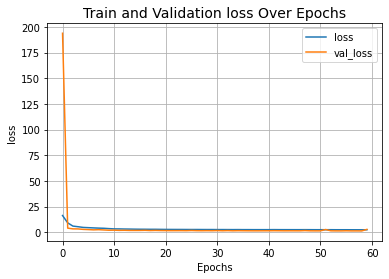

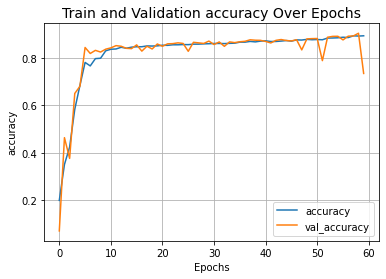

In [ ]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

Validation prediction shape: (1, 50000, 11)
Index selected: 0


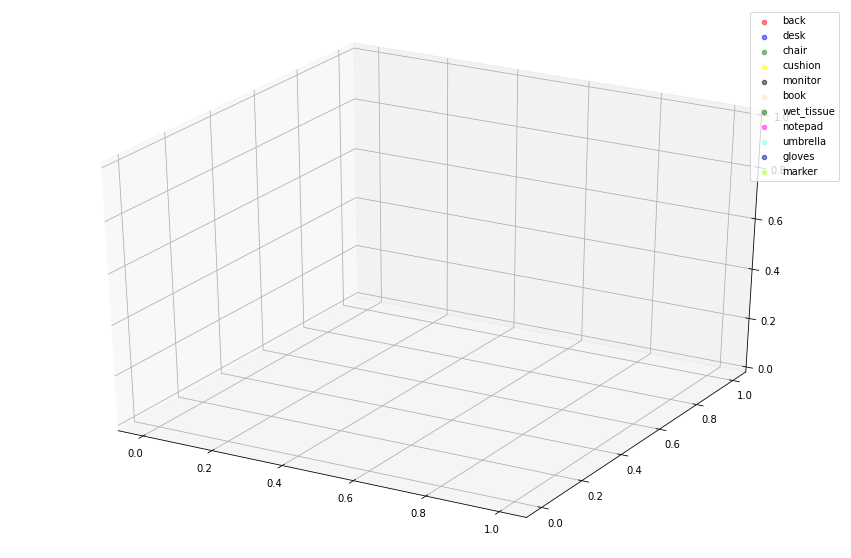

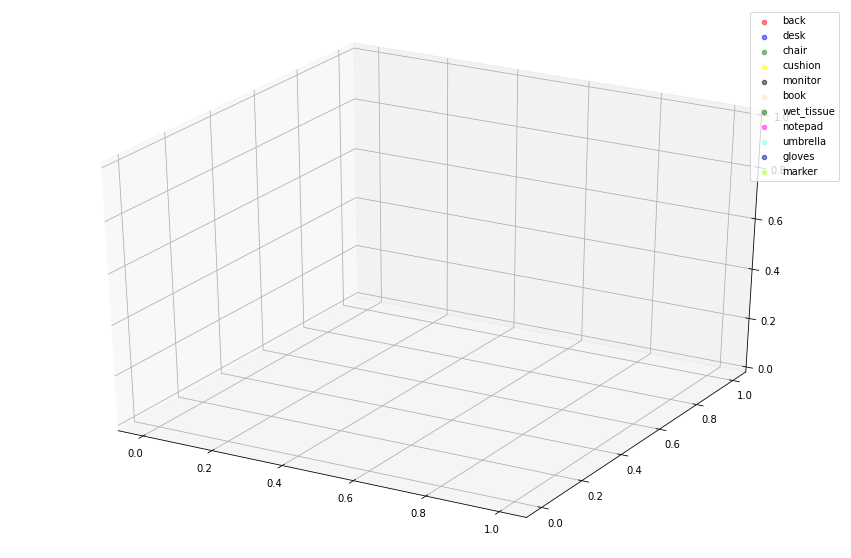

In [ ]:
validation_batch = next(iter(val_dataset))
val_predictions = segmentation_model.predict(validation_batch[0])
print(f"Validation prediction shape: {val_predictions.shape}")

def visualize_single_point_cloud(point_clouds, label_clouds, idx):
    label_map = LABELS
    point_cloud = point_clouds[idx]
    label_cloud = label_clouds[idx]
    visualize_data(point_cloud, [label_map[np.argmax(label)] for label in label_cloud])


idx = np.random.choice(len(validation_batch[0]))
print(f"Index selected: {idx}")

# Plotting with ground-truth.
visualize_single_point_cloud(validation_batch[0], validation_batch[1], idx)

# Plotting with predicted labels.
visualize_single_point_cloud(validation_batch[0], val_predictions, idx)

for i, batch in enumerate(validation_batch[0]):
  np.savetxt('valid'+str(i)+'.txt',batch)
for i, batch in enumerate(validation_batch[1]):
  np.savetxt('valid_result'+str(i)+'.txt',batch)
for i, batch in enumerate(val_predictions):
  np.savetxt('result'+str(i)+'.txt',val_predictions[0])

In [ ]:
NUM_OF_VAL = 7
for i in range(NUM_OF_VAL):
  validation_batch = next(iter(val_dataset))
  val_predictions = segmentation_model.predict(validation_batch[0])
  np.savetxt('drive/MyDrive/pointnet/res/valid'+str(i)+'.txt',validation_batch[0][i])
  np.savetxt('drive/MyDrive/pointnet/res/valid_result'+str(i)+'.txt',validation_batch[1][i])
  np.savetxt('drive/MyDrive/pointnet/res/result'+str(i)+'.txt',val_predictions[i])